# Um Modelo Preditivo Para Classificação de Risco de Mortalidade de Pacientes com COVID-19 no Rio Grande do Sul

Durante a pandemia de COVID-19 os sistemas de saúde do mundo inteiro enfrentam problemas sem precedentes quanto a disponibilidade e alocação de recursos comorespiradores e leitos de UTI (LATIF et al., 2020).  Estudos mostram que modelos de aprendizagem de máquina (*machine learning*) conseguem classificar chances de recuperação ou risco de óbito com até 94% de acurácia (IWENDI et al., 2020) e 0.74 de pontuação ROC (*Receiver Operating Charachteristic Curve) - AUC (Area Under the Curve*) parapredição de admissão em UTI (YADAW et al., 2020) (ASSAF et al., 2020), contribuindo para amenizar alguns dos problemas relacionados a alocação de recursos.

Os modelos de predição enfrentam pelo menos dois desafios significativos. O primeiro deles diz respeito à limpeza dos dados, isto é, eliminar erros, inconsistências ou pontos fora da curva (outliers, em inglês). O segundo desafio é encontrar modelos, características e métricas de avaliação de algoritmos de aprendizagem de máquina que garantam a credibilidade dos modelos preditivos. Com uma menção honrosa ao desafio de dispor dados para que todas as análises possam ser feitas.

O objetivo desse trabalho é propor um modelo preditivo para classificação de risco de mortalidade de pacientes com COVID-19 no estado do Rio Grande do Sul. Para atingir o objetivo, o trabalho foi dividido em duas etapas. A primeira consiste na limpeza dos dados, e a segunda é propor e validar o uso de técnicas de aprendizagem de máquina para auxiliar na tomada de decisões.

## 1. Aquisição dos dados

Os dados para a análise, no presente projeto, vêm do [Painel Corona Vírus RS](https://ti.saude.rs.gov.br/covid19/), e compreende o perído de 29/02/2020 a 11/03/2021. Essa plataforma, por sua vez, usa como fontes os dois sistemas de notificações oficiais do Ministério da Saúde no monitoramento da doença: o e-SUS Notifica e o Sistema de Informação da Vigilância Epidemiológica da Gripe (Sivep-Gripe). 

O e-SUS Notifica (que antes era chamado de e-SUS VE) é a ferramenta na qual são notificados os casos de síndrome gripal (SG) que não precisam de internação hospitalar. Casos de SG atendidos em Unidades Sentinelas são notificados no SIVEP-Gripe (Síndrome Gripal). Nos casos em que a pessoa apresenta quadro mais grave da infecção (Síndrome Respiratória Aguda Grave – SRAG) e é necessária a hospitalização, a notificação é feita no SIVEP-Gripe (SRAG Hospitalizado)..

Ambos os sistemas são utilizados pelos serviços de saúde públicos e privados e pelas secretarias municipais de saúde para realização das notificações e monitoramento dos casos e seus contactantes (sintomas, exames realizados, resultados, evolução, entre outros).


In [1]:
# carregamento de bibliotecas e definição de padrões de estilo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

%matplotlib inline
pd.set_option("display.precision", 2)
sns.set_context("talk") # paper, notebook, talk, and poster
sns.set_style("whitegrid")


In [2]:
df = pd.read_csv("files/20210311.csv", sep=';')

## 2. EDA (*Exploratory Data Analysis*)

Para o primeiro entendimento dos dados que farão parte da solução proposta, precisamos utilizar de métodos que nos ajudem a vislumbrar seus padrões, "formas" e inclusive pontos fora da curva. Antes de seguirmos para as devidas limpezas ou extrações, vamos utilizar das bibliotecas para análise e visualização de dados do Python, Pandas, Numpy, Matplotlib e Seaborn para nos ajudar a entender o contexto das mesmas.

### Quantidade de linhas e colunas

In [3]:
df.shape

(713614, 29)

O arquivo contem 713614 linhas e 29 colunas. Sendo as colunas:

### Visualização do nome das colunas

In [4]:
df.columns

Index(['COD_IBGE', 'MUNICIPIO', 'COD_REGIAO_COVID', 'REGIAO_COVID', 'SEXO',
       'FAIXAETARIA', 'CRITERIO', 'DATA_CONFIRMACAO', 'DATA_SINTOMAS',
       'DATA_EVOLUCAO', 'EVOLUCAO', 'HOSPITALIZADO', 'FEBRE', 'TOSSE',
       'GARGANTA', 'DISPNEIA', 'OUTROS', 'CONDICOES', 'GESTANTE',
       'DATA_INCLUSAO_OBITO', 'DATA_EVOLUCAO_ESTIMADA', 'RACA_COR',
       'ETNIA_INDIGENA', 'PROFISSIONAL_SAUDE', 'BAIRRO', 'HOSPITALIZACAO_SRAG',
       'FONTE_INFORMACAO', 'PAIS_NASCIMENTO', 'PES_PRIV_LIBERDADE'],
      dtype='object')

### Cabeçalho

In [5]:
df.head()

,COD_IBGE,MUNICIPIO,COD_REGIAO_COVID,REGIAO_COVID,SEXO,FAIXAETARIA,CRITERIO,DATA_CONFIRMACAO,DATA_SINTOMAS,DATA_EVOLUCAO,...,DATA_INCLUSAO_OBITO,DATA_EVOLUCAO_ESTIMADA,RACA_COR,ETNIA_INDIGENA,PROFISSIONAL_SAUDE,BAIRRO,HOSPITALIZACAO_SRAG,FONTE_INFORMACAO,PAIS_NASCIMENTO,PES_PRIV_LIBERDADE
0,430003,ACEGUÁ,16,BAGE - R22,Feminino,40 a 49,RT-PCR,05/10/2020,29/09/2020,NaN,...,NaN,13/10/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
1,430003,ACEGUÁ,16,BAGE - R22,Masculino,15 a 19,RT-PCR,06/10/2020,06/10/2020,NaN,...,NaN,20/10/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
2,430003,ACEGUÁ,16,BAGE - R22,Feminino,50 a 59,TESTE RÁPIDO,19/10/2020,05/10/2020,NaN,...,NaN,19/10/2020,BRANCA,NAO ENCONTRADO,NAO,ZONA RURAL,NAO,E-SUS,BRASIL,NAO
3,430003,ACEGUÁ,16,BAGE - R22,Feminino,50 a 59,RT-PCR,26/11/2020,18/11/2020,01/12/2020,...,NaN,NaN,BRANCA,NAO ENCONTRADO,NAO INFORMADO,ASSENTAMENTO,SIM,SIVEP HOSP,BRASIL,NAO
4,430003,ACEGUÁ,16,BAGE - R22,Feminino,40 a 49,RT-PCR,09/12/2020,01/12/2020,NaN,...,NaN,15/12/2020,NAO INFORMADO,NAO ENCONTRADO,SIM,ZONA RURAL,NAO,E-SUS,BRASIL,NAO


### Visualização de valores faltantes

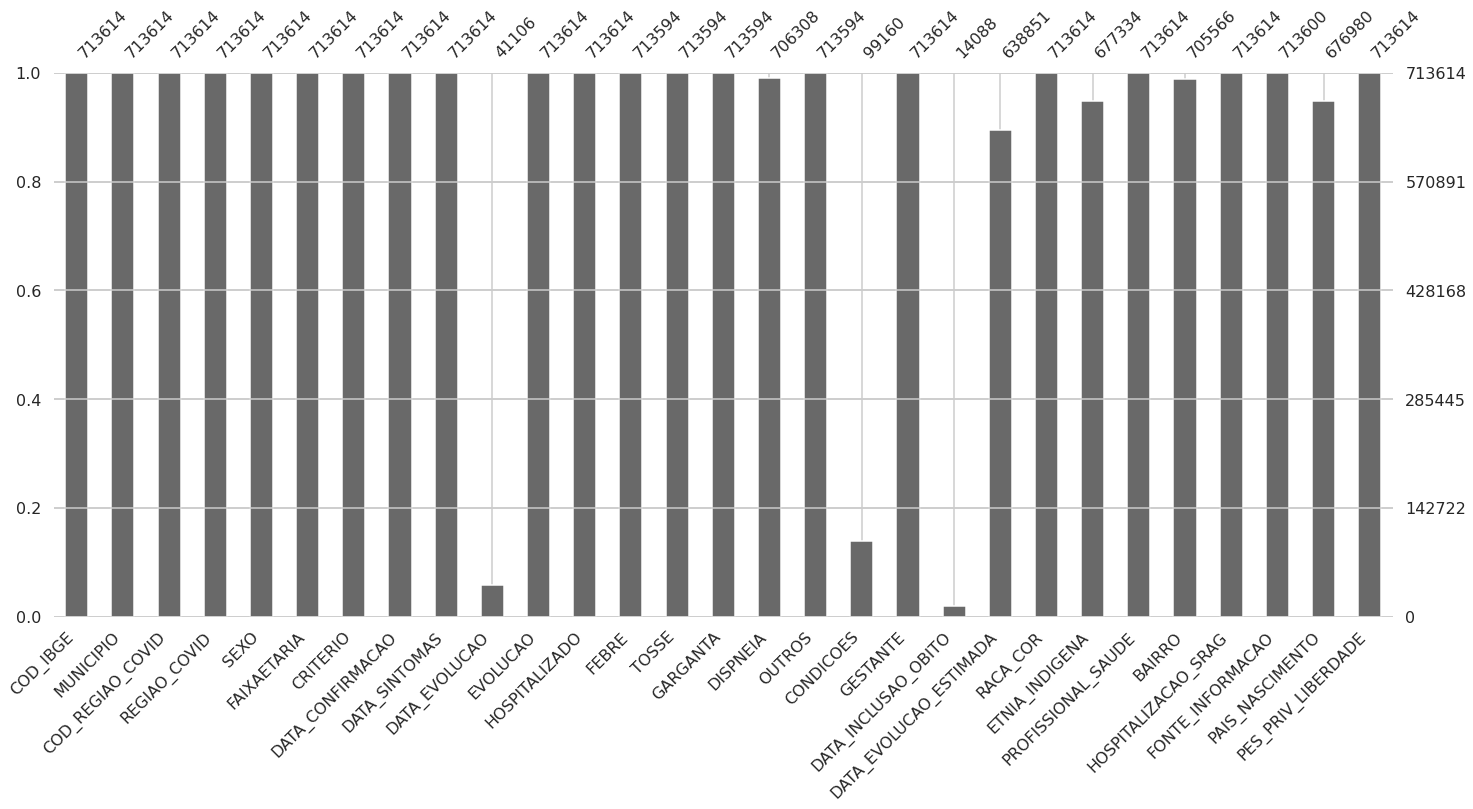

In [6]:
msno.bar(df);

---

### Valores possíveis para campos categóricos

**```SEXO```**

In [7]:
df['SEXO'].value_counts()

Feminino     381269
Masculino    332345
Name: SEXO, dtype: int64

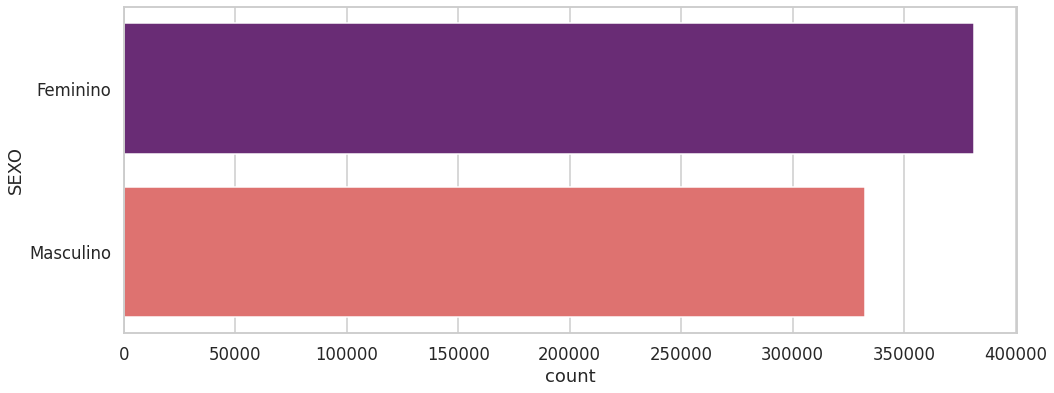

In [8]:
plt.figure(figsize=(16, 6))
sns.countplot(y='SEXO', data=df, palette="magma");


**```FAIXAETARIA```**

In [9]:
df['FAIXAETARIA'].value_counts()

30 a 39      159093
20 a 29      135501
40 a 49      129258
50 a 59      105040
60 a 69       68111
70 a 79       33757
15 a 19       29934
80 e mais     17351
10 a 14       13052
05 a 09       10447
01 a 04        8729
<1             3341
Name: FAIXAETARIA, dtype: int64

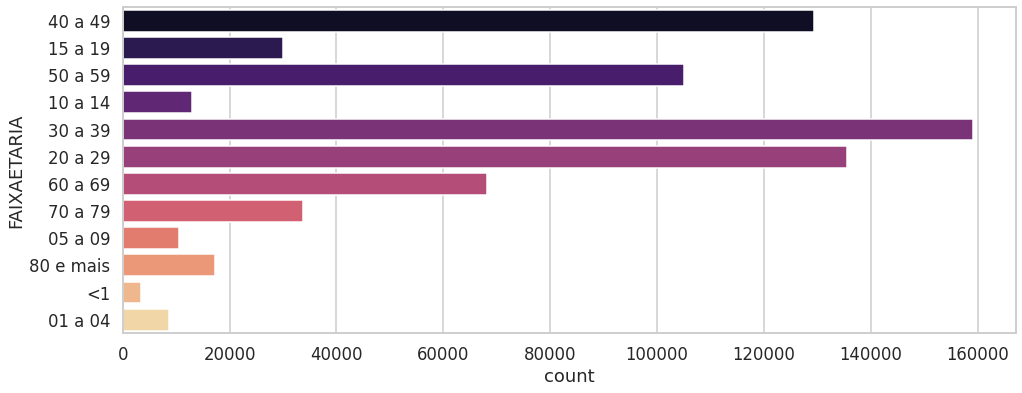

In [10]:
plt.figure(figsize=(16, 6))
sns.countplot(y='FAIXAETARIA', data=df, palette="magma");

**```FAIXAETARIA```**

In [11]:
df['CRITERIO'].value_counts()

RT-PCR                    410044
TESTE RÁPIDO              282641
Outros Testes              13642
Clínico                     3372
Clínico-Imagem              2136
Clínico Epidemiológico      1708
Outros testes                 42
Ignorado                      29
Name: CRITERIO, dtype: int64

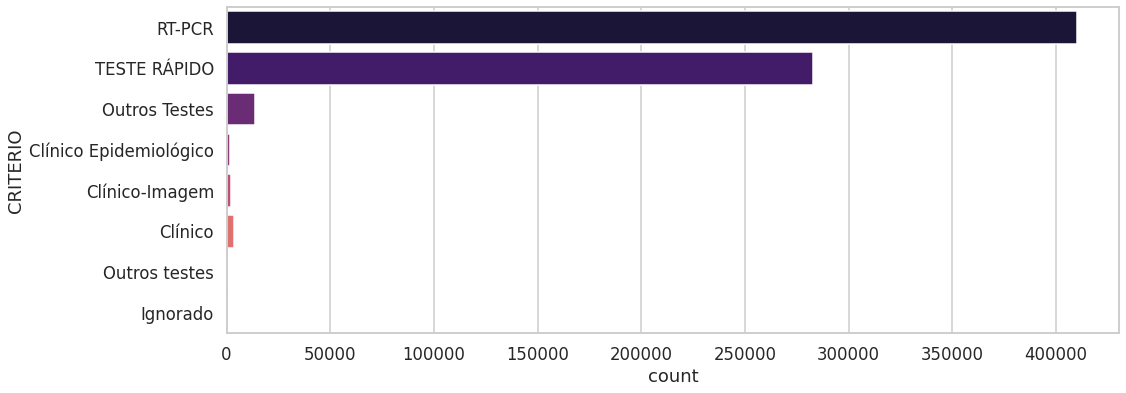

In [12]:
plt.figure(figsize=(16, 6))
sns.countplot(y='CRITERIO', data=df, palette="magma");

**```EVOLUCAO```**

In [13]:
df['EVOLUCAO'].value_counts()

RECUPERADO             663897
EM ACOMPANHAMENTO       35568
OBITO                   14087
OBITO OUTRAS CAUSAS        62
Name: EVOLUCAO, dtype: int64

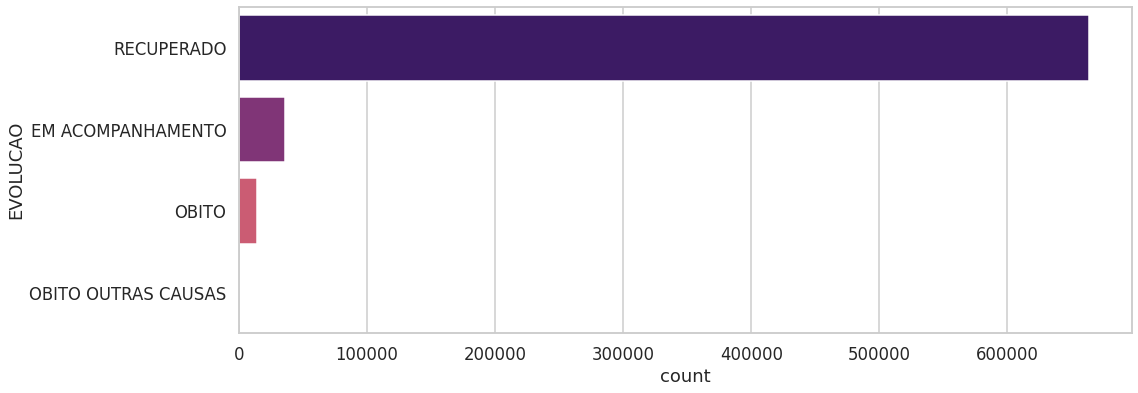

In [14]:
plt.figure(figsize=(16, 6))
sns.countplot(y='EVOLUCAO', data=df, palette="magma");

**```CONDICOES```**

In [15]:
df['CONDICOES'].value_counts()

Doenças cardíacas crônicas                                                                                                                                                                                                                                                                           23000
Doenças respiratórias crônicas descompensadas                                                                                                                                                                                                                                                         9968
Diabetes                                                                                                                                                                                                                                                                                              7765
Outros                                                                                                 

---
**```RACA_COR```**


In [16]:
df['RACA_COR'].value_counts()

BRANCA           540189
NAO INFORMADO    111341
PRETA             27571
PARDA             26620
AMARELA            6257
INDIGENA           1636
Name: RACA_COR, dtype: int64

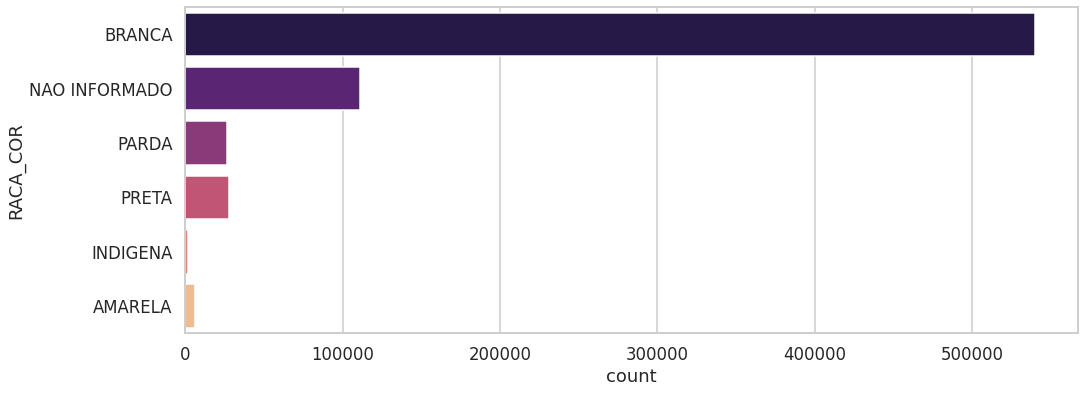

In [17]:
plt.figure(figsize=(16, 6))
sns.countplot(y='RACA_COR', data=df, palette="magma");

In [18]:
df['FEBRE'].value_counts()

NAO    483245
SIM    230349
Name: FEBRE, dtype: int64

In [19]:
df['OUTROS'].value_counts()

SIM    389663
NAO    323931
Name: OUTROS, dtype: int64

### Conclusão da visualização dos dados

Os dados parecem já estar limpos, com exceção do campo `CONDICOES` de onde pode-se extrair mais informações. No geral, as informações que nos interessam são preenchidas apenas com "SIM" ou "NÃO", que são os campos de sintomas, como `FEBRE`. E o campo `EVOLUCAO`, que é a nossa variavel preditora. A faixa etária já está bem definida, e pode-se apenas definir a ordem de precedência de cada categoria.

___

## 3. Limpeza e transformação dos dados

A **transformação** refere-se aos processos que convergem emuma reestruturação dos dados a partir das fontes originais. Em outras palavras, o objetivo da transformação é, partindo de um estado complexo e ilegível dos dados originais, apresentar os dados em novos formatos e estruturas que facilitema análise e a geração de *insights*.

Vamos extrair os dados da coluna `CONDICOES`, primeiramente visualizando uma nuvem de palavras para entendermos as condições ali presentes.

In [20]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### Remoção dos valores faltantes
O primeiro comando que deve ser executado é a remoção das linhas onde apresentam dados ausentes na coluna summary, nesta variável encontra-se os textos utilizados para realizar o *wordcloud*.

In [21]:
df.dropna(subset=['CONDICOES'], axis=0, inplace=True)

### Junção das strings
Após a remoção das linhas, precisamos unir todas as palavras em uma única *string*. 

In [22]:
conditions = df['CONDICOES'] # pegar apenas as condicoes
all_conditions = " ".join(s for s in conditions) # unir tudo em uma string

### Eliminar *stopwords*
Para criação de nuvem de palavras, algumas preposições ou palavras devem ser removidas (*e.g.*, do, da, dos, das, no).

In [23]:
stopwords = set(STOPWORDS)
stopwords.update(["da", "meu", "em", "você", "de", "ao", "os"]) # acréscimo de mais stopwords

In [24]:
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='white', width=1600,                            
                      height=1000).generate(all_conditions)

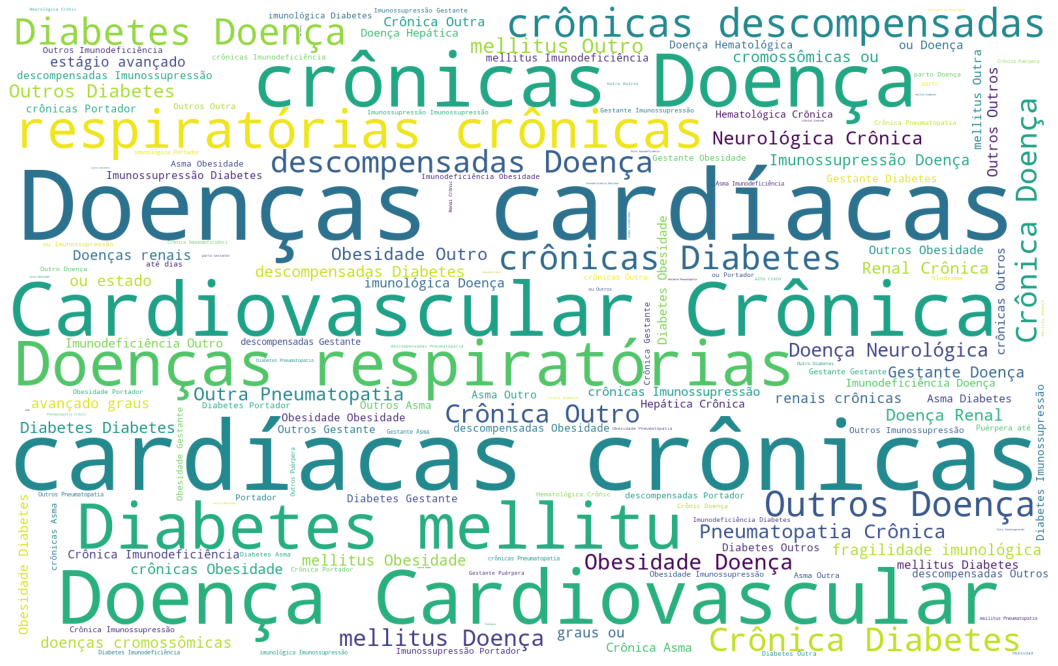

In [25]:
fig, ax = plt.subplots(figsize=(20,12))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()

plt.imshow(wordcloud)                 
wordcloud.to_file('condicoes.png',);

### Conclusão 

Ao analisar a nuvem de palavras, podemos visualizar algumas informações das quais podemos extrair novos campos.

Dentre estes, devemos nos atentar para alguns erros de português ou mesmo para sinônimos (*e.g* mellitus e diabetes).

Os campos que serão extraídos compreendem:

- `DIABETES`: quando 'diabetes', 'mellitus' ou 'mellitu'
- `CARDIOVASCULAR`: quando 'cardiovascular', 'cardíacas'
- `PUERPERA`: quando 'puerpera'
- `OBESIDADE`: quando 'obesidade'
- `PNEUMOPATIA`: quando 'pneumopatia'
- `GESTANTE`: quando 'gestante'
- `DOENCA_PULMONAR`: quando 'respiratórias', 'asma'
- `IMUNOSSUPRESSÃO`: quando 'imunossupressão'
- `IMUNODEFICIENCIA`: quando 'imunodeficiência'
- `DOENCA_RENAL`: quando 'renais'
___


### Limpeza de dados

Para podermos extair os dados, vamos normalizar todos os campos, removendo os acentos e deixando tudo em caixa baixa.

In [26]:
import unidecode

In [27]:
df['CONDICOES'] = df['CONDICOES'].apply(unidecode.unidecode) # removendo acentos
df['CONDICOES'] = df['CONDICOES'].apply(str.lower) # deixando caixa baixa

### Mineração dos dados

Com os dados normalizados, vamos extrair os campos já mencionados.

In [28]:
df['DIABETES'] = ['SIM' if any(string in str(row) for string in ['diabetes', 'mellitus', 'mellitu']) else 
                  'NÃO' for row in df['CONDICOES']]

df['CARDIOVASCULAR'] = ['SIM' if any(string in str(row) for string in ['cardiovascular', 'cardiacas']) else 
                        'NÃO' for row in df['CONDICOES']]

df['PUERPERA'] = ['SIM' if any(string in str(row) for string in ['puerpera']) else 
                  'NÃO' for row in df['CONDICOES']]

df['OBESIDADE'] = ['SIM' if any(string in str(row) for string in ['obesidade']) else 
                   'NÃO' for row in df['CONDICOES']]

df['PNEUMOPATIA'] = ['SIM' if any(string in str(row) for string in ['pneumopatia']) else 
                     'NÃO' for row in df['CONDICOES']]

df['GESTANTE'] = ['SIM' if any(string in str(row) for string in ['gestante']) else 
                  'NÃO' for row in df['CONDICOES']]

df['DOENCA_PULMONAR'] = ['SIM' if any(string in str(row) for string in ['respiratorias', 'asma']) else 
                         'NÃO' for row in df['CONDICOES']]

df['IMUNOSSUPRESSAO'] = ['SIM' if any(string in str(row) for string in ['imunossupressao']) else 
                         'NÃO' for row in df['CONDICOES']]

df['IMUNODEFICIENCIA'] = ['SIM' if any(string in str(row) for string in ['imunodeficiência']) else 
                          'NÃO' for row in df['CONDICOES']]

df['DOENCA_RENAL'] = ['SIM' if any(string in str(row) for string in ['renais']) else 
                      'NÃO' for row in df['CONDICOES']]

In [29]:
df.columns

Index(['COD_IBGE', 'MUNICIPIO', 'COD_REGIAO_COVID', 'REGIAO_COVID', 'SEXO',
       'FAIXAETARIA', 'CRITERIO', 'DATA_CONFIRMACAO', 'DATA_SINTOMAS',
       'DATA_EVOLUCAO', 'EVOLUCAO', 'HOSPITALIZADO', 'FEBRE', 'TOSSE',
       'GARGANTA', 'DISPNEIA', 'OUTROS', 'CONDICOES', 'GESTANTE',
       'DATA_INCLUSAO_OBITO', 'DATA_EVOLUCAO_ESTIMADA', 'RACA_COR',
       'ETNIA_INDIGENA', 'PROFISSIONAL_SAUDE', 'BAIRRO', 'HOSPITALIZACAO_SRAG',
       'FONTE_INFORMACAO', 'PAIS_NASCIMENTO', 'PES_PRIV_LIBERDADE', 'DIABETES',
       'CARDIOVASCULAR', 'PUERPERA', 'OBESIDADE', 'PNEUMOPATIA',
       'DOENCA_PULMONAR', 'IMUNOSSUPRESSAO', 'IMUNODEFICIENCIA',
       'DOENCA_RENAL'],
      dtype='object')

___

## Exportação

Com os dados limpos e com a mineração já feita, vamos selecionar a fatia dos dados que utilizaremos para alimntar nosso modelo preditivo. Como queremos prever a chance de óbito, precisamos apenas dos que possuem evolução do caso, e esta deve ser diferente de 'EM ACOMPANHAMENTO' e 'OBITO POR OUTRAS CAUSAS'. Assim como não precisamos de campos como 'municipio' ou 'cod_ibge'.


#### REmoção de campos que não utilizaremos

In [30]:
df.drop(columns=['COD_IBGE', 'MUNICIPIO', 'COD_REGIAO_COVID', 'REGIAO_COVID', 'CONDICOES', 
                 'FONTE_INFORMACAO', 'BAIRRO', 'PAIS_NASCIMENTO', 'PES_PRIV_LIBERDADE', 'PROFISSIONAL_SAUDE'], inplace=True)

df.columns

Index(['SEXO', 'FAIXAETARIA', 'CRITERIO', 'DATA_CONFIRMACAO', 'DATA_SINTOMAS',
       'DATA_EVOLUCAO', 'EVOLUCAO', 'HOSPITALIZADO', 'FEBRE', 'TOSSE',
       'GARGANTA', 'DISPNEIA', 'OUTROS', 'GESTANTE', 'DATA_INCLUSAO_OBITO',
       'DATA_EVOLUCAO_ESTIMADA', 'RACA_COR', 'ETNIA_INDIGENA',
       'HOSPITALIZACAO_SRAG', 'DIABETES', 'CARDIOVASCULAR', 'PUERPERA',
       'OBESIDADE', 'PNEUMOPATIA', 'DOENCA_PULMONAR', 'IMUNOSSUPRESSAO',
       'IMUNODEFICIENCIA', 'DOENCA_RENAL'],
      dtype='object')

#### Seleção da fatia que utilizaremos

In [31]:
df = df[(df['EVOLUCAO'] == 'OBITO') | (df['EVOLUCAO'] == 'RECUPERADO')]

In [32]:
df['EVOLUCAO'].value_counts()

RECUPERADO    81964
OBITO         12486
Name: EVOLUCAO, dtype: int64

#### Exportacao

In [33]:
df.to_csv("covid_11_marco.csv", sep=';', index=False)